In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from ML_OPs.DataProcessor import load_data

data_set = load_data()
data_set.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_electrocardiographic,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
from typing import List
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, Normalizer, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def scale_normally_distributed_features()-> Pipeline:
    return Pipeline([
        ("min_max_scaler", MinMaxScaler()),
        ("normalizer", Normalizer(norm="l1"))
    ])

def scale_other_feature_distributions()-> Pipeline:
    return Pipeline([
        ("quantile_tranformer", QuantileTransformer(n_quantiles=100, output_distribution="normal")),
        ("normalizer", Normalizer(norm="l1"))
    ])
def scale_numeric_features(norm_scaler: Pipeline, other_scaler: Pipeline,
                           normal_features: List[str], other_features: List[str], categorical_features: List[str] = None)->ColumnTransformer:
    return ColumnTransformer([
        ("normal_scaler", norm_scaler, normal_features),
        ("lopsided_scaler", other_scaler, other_features),
        ("categoriacal_encoding", OrdinalEncoder(), categorical_features)
    ])

In [13]:
from ML_OPs.DataProcessor import get_numerical_features, get_categorical_features

num_features = get_numerical_features()
cat_features = get_categorical_features()
num_features.remove("age")
cat_features.remove("target")
print(num_features)
print(cat_features)
preprocessing_pipeline = scale_numeric_features(
    norm_scaler=scale_normally_distributed_features(),
    other_scaler=scale_other_feature_distributions(),
    normal_features=["age"],
    other_features=num_features,
    categorical_features=cat_features

)
preprocessing_pipeline

['cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']
['chest_pain_type', 'rest_electrocardiographic', 'st_slope', 'thalassemia', 'sex', 'fasting_blood_sugar', 'exercise_induced_angina']


ColumnTransformer(transformers=[('normal_scaler',
                                 Pipeline(steps=[('min_max_scaler',
                                                  MinMaxScaler()),
                                                 ('normalizer',
                                                  Normalizer(norm='l1'))]),
                                 ['age']),
                                ('lopsided_scaler',
                                 Pipeline(steps=[('quantile_tranformer',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal')),
                                                 ('normalizer',
                                                  Normalizer(norm='l1'))]),
                                 ['cholesterol', 'resting_blood_pressure',
                                  'max_heart_rate_achieved', 'st_depression',
                         

In [14]:
y = data_set[["target"]]
_x = data_set.drop("target", axis=1)

In [15]:
x = preprocessing_pipeline.fit_transform(_x)
y = y.to_numpy()

## Model Creation and evaluation

In [16]:
from ML_OPs.ModelEvaluation import score_summary
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

x_train, x_test , y_train, y_test = train_test_split(x, np.ravel(y))
log_regressor = LogisticRegression().fit(x_train, y_train)
nearest_neighbour_classifier = KNeighborsClassifier().fit(x_train, y_train)
decision_tree_classifier = DecisionTreeClassifier().fit(x_train, y_train)
random_forest_classifier = RandomForestClassifier().fit(x_train, y_train)
gradient_boosting_classifier = GradientBoostingClassifier().fit(x_train, y_train)
ada_classifier = AdaBoostClassifier().fit(x_train, y_train)

In [25]:
classifiers = [log_regressor, nearest_neighbour_classifier, decision_tree_classifier, random_forest_classifier, gradient_boosting_classifier, ada_classifier]
summary = score_summary(classifiers=classifiers, x_test=x_test, y_test=y_test)

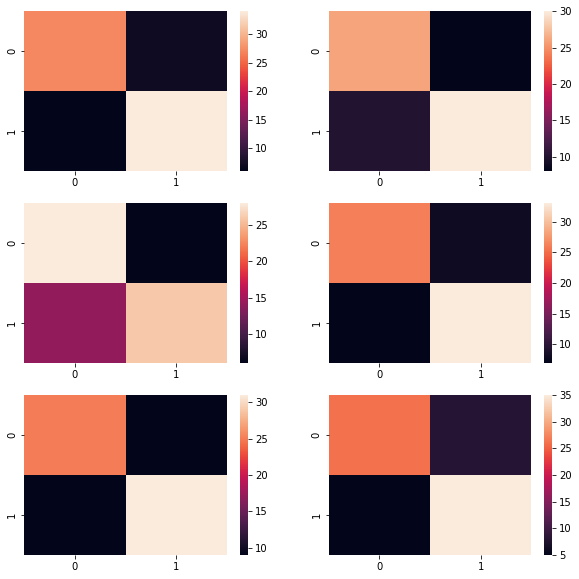

In [18]:
from ML_OPs.Visualizer import plot_confusion_matrix
plot_confusion_matrix(classifiers, x_test, y_test, n_cols=2)

In [26]:
summary

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,LogisticRegression,82.43,0.89,0.85,0.83,0.84
1,KNeighborsClassifier,75.68,0.84,0.75,0.79,0.77
2,DecisionTreeClassifier,72.97,0.74,0.65,0.81,0.72
3,RandomForestClassifier,79.73,0.87,0.82,0.80,0.81
4,GradientBoostingClassifier,75.68,0.88,0.78,0.78,0.78
5,AdaBoostClassifier,82.43,0.88,0.88,0.81,0.84


In [30]:
summary.sort_values(by="Accuracy", ascending=False)\
    .style.background_gradient(cmap='coolwarm')\
    .bar(subset=["ROC_AUC",], color='#6495ED')\
    .bar(subset=["Recall"], color='#ff355d')\
    .bar(subset=["Precision"], color='lightseagreen')\
    .bar(subset=["F1"], color='gold')

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
0,LogisticRegression,82.430000,0.890000,0.850000,0.830000,0.840000
5,AdaBoostClassifier,82.430000,0.880000,0.880000,0.810000,0.840000
3,RandomForestClassifier,79.730000,0.870000,0.820000,0.800000,0.810000
1,KNeighborsClassifier,75.680000,0.840000,0.750000,0.790000,0.770000
4,GradientBoostingClassifier,75.680000,0.880000,0.780000,0.780000,0.780000
2,DecisionTreeClassifier,72.970000,0.740000,0.650000,0.810000,0.720000


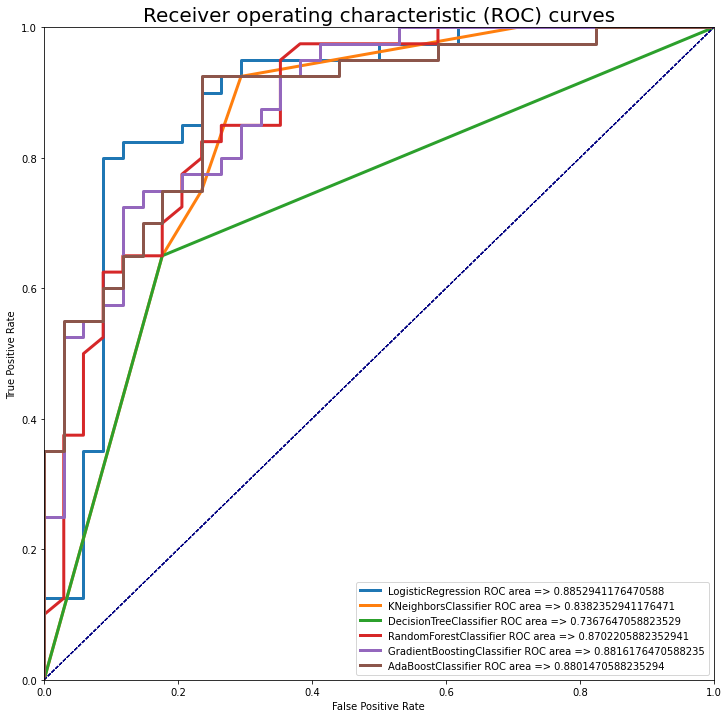

In [31]:
from ML_OPs.Visualizer import plot_roc_auc_curves

plot_roc_auc_curves(classifiers=classifiers, x_test=x_test, y_test=y_test)

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RepeatedStratifiedKFold

lr = LogisticRegression(tol=1e-4, max_iter=1000, random_state=42)
search_space = dict(C = uniform(loc=0, scale=5),
                    penalty=["l1", "l2"],
                    solver = ["liblinear"])

search = RandomizedSearchCV(lr, search_space, random_state=42, cv=5, scoring="f1")
rand_search = search.fit(x_train, y_train)
print(f"Best Parameters => {rand_search.best_params_}")

Best Parameters => {'C': 0.917173949330819, 'penalty': 'l2', 'solver': 'liblinear'}


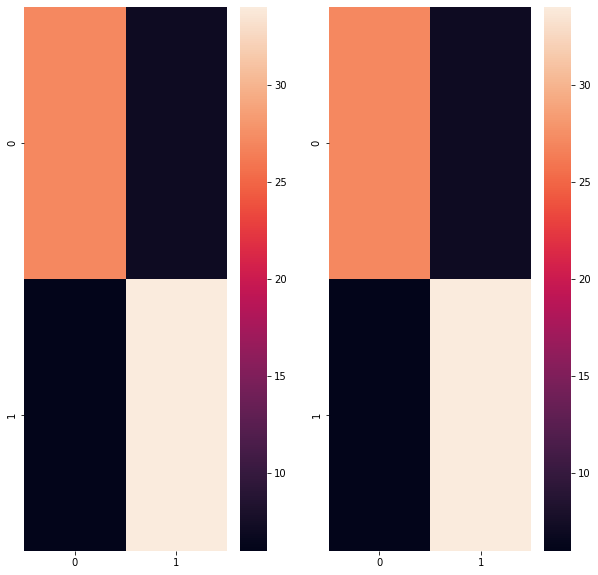

In [36]:
params = rand_search.best_params_
optimal_logistic_regression = LogisticRegression(**params)
optimal_logistic_regression.fit(x_train, y_train)
plot_confusion_matrix([optimal_logistic_regression, log_regressor], x_test, y_test)

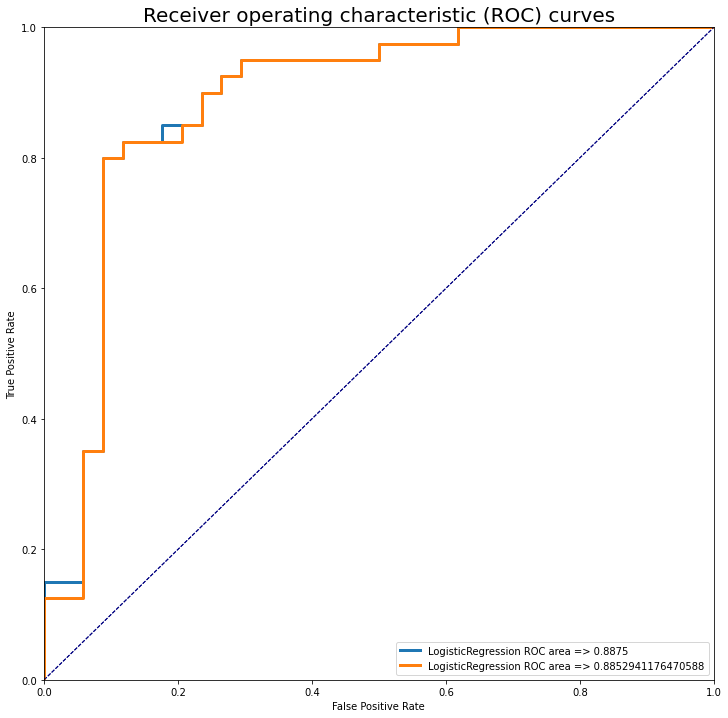

In [39]:
plot_roc_auc_curves([optimal_logistic_regression, log_regressor], x_test, y_test)